In [1]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Load all the datasets and extract the climate quotes for each year into a separate pickle file

In [ ]:
# RUN ONLY ONCE
# iteratively extract climate quotation datasets for each year

for year in range(2015, 2021):
    print(year)
    df_reader = pd.read_json('data/quotebank/quotes-{}.json.bz2'.format(year), lines=True, compression='bz2', chunksize=10000)

    climate_quotes = []
    for chunk in df_reader:
        df = chunk[chunk.quotation.str.contains('climate', case=False, na=False)]
        climate_quotes.append(df)
    print('Chunks for year {} done'.format(year))
    climate_df = pd.concat(climate_quotes)
    # pickle pickle pickle
    climate_df.to_pickle('data/climate_df_{}.pkl'.format(year))
    print('Pickle done')

2015
Chunks for year 2015 done
Pickle done
2016
Chunks for year 2016 done
Pickle done
2017


**Loading the climate dataframes pickles for each year into a dictionary**

In [2]:
climate_dfs = {}
for i in range(2015, 2021):
    climate_dfs['{}'.format(i)] = pd.read_pickle('data/climate_df_{}.pkl'.format(i))

## Wiki data

In [3]:
# load wiki data
wiki_data = pd.read_parquet('parquet-data/speaker_attributes.parquet')

# load the labels for wiki data
wiki_labels = pd.read_csv('data/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [4]:
wiki_data.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


**Cleaning dataset**

In [5]:
# set a unique label_name for speakers with several versions of name
# RESOLVES THE TRUMP PROBLEM
def clean_name(df, name):
    
    df_copy = df.copy()
    
    df_name = df[df['speaker'].apply(lambda x: name in x)]
    # get the qid of the speaker in wiki_data
    wiki_qid = df_name['qids'].iloc[0][0]
    # get the label of speaker
    label_name = wiki_data[wiki_data['id'] == wiki_qid]['label'].iloc[0].lower()
    #replace speaker with his label
    df_copy = df.replace(df_name['speaker'].iloc[0], label_name)
    
    return df_copy

In [6]:
def clean_df(df):
    """Cleans the dataset for speakers only for now"""
    
    # remove all the 'None' speakers
    df = df[df['speaker'] != 'None']
    # all names to lower case
    df['speaker'] = df['speaker'].str.lower()
    
    #clean different Trump names
    trump_names = df[df['speaker'].apply(lambda x: ('trump' in x) and ('president' in x) or x=='donald trump' or x=='donald j. trump')]['speaker'].unique()
    for t in trump_names:
        df = clean_name(df, t)
        
    # clean different Obama names
    obama_names = df[df['speaker'].apply(lambda x: ('barack' in x) or ('president' in x and 'obama' in x))]['speaker'].unique()
    for i in obama_names:
        df = clean_name(df, i)
    
    
    return df

We clean climate dataset 2018

In [8]:
climate_dfs['2018'] = clean_df(climate_dfs['2018'])

**Top 10 functions**

In [10]:
def top_speakers(df):
    """function to extract the top 10 speakers"""
    
    top_speakers = df.groupby('speaker')['speaker'].count().sort_values(ascending=False).to_frame().add_suffix('_count')
    top_speakers.reset_index(drop=False, inplace=True)
    
    return top_speakers.head(10)


def top_quotations(df):
    """function to extract the top 10 msot repeated quotations"""
    
    top_quotations = df.sort_values('numOccurrences', ascending=False)[['speaker', 'quotation', 'numOccurrences']]
    # remove quotations of unidentified speakers
    top_quotations.reset_index(drop=True, inplace=True)
    
    return top_quotations.head(10)

In [11]:
# quick visualization
def visualize_top(x, y):
    plt.figure(figsize=(16, 6))
    #plt.bar(x, y, color=['orange', 'blue', 'green' , 'red', 'brown', 'yellow', 'pink', 'gray', 'lime', 'darkblue'])
    sns.barplot(x=x,y=y)
    plt.title("Most quoted speakers")
    

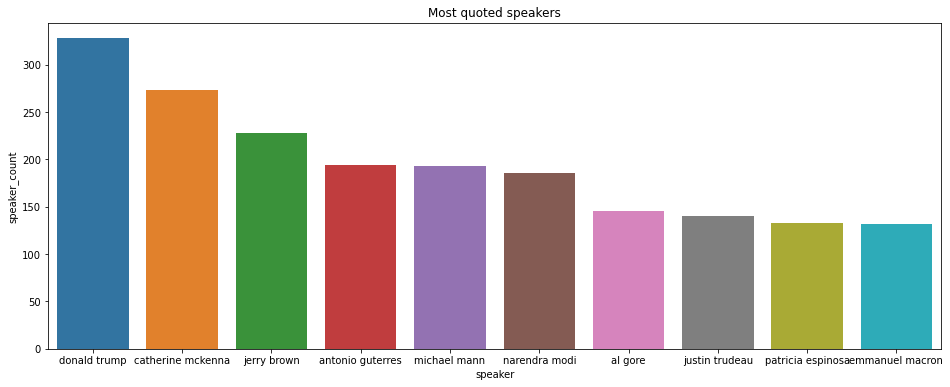

In [19]:
# show top speakers from 2017
speakers_10 = top_speakers(climate_dfs['2018'])
visualize_top(speakers_10.speaker, speakers_10.speaker_count)

In [13]:
# show top quotations from 2015
top_quotations(climate_dfs['2018'])

,speaker,quotation,numOccurrences
0,valeri liukin,"the present climate causes me, and more import...",578
1,greta thunberg,School strike for the Climate.,425
2,greta thunberg,"School Strike For Climate,",302
3,antonio guterres,Even as we witness devastating climate impacts...,296
4,jim steele,What's happened with the more warming climate ...,288
5,donald trump,"There is a cooling, and there's a heating. I m...",287
6,donald trump,"I'm not denying climate change,",285
7,kim jong un,"warm climate of reconciliation and dialogue,",283
8,dave robertson,I would say that the obvious inability in the ...,278
9,katharine hayhoe,"As a climate scientist, it is almost surreal.",256


In [14]:
from tld import get_tld

def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.domain

# function extracting the top 10 newspapers mentioning climate 
def top_newspapers(df):
    top_newspapers = pd.Series([x for _list in df['urls'] for x in _list]).apply(lambda u: get_domain(u)).value_counts()
    top_newspapers = top_newspapers.to_frame().reset_index(drop=False)
    top_newspapers.columns = ['newspaper', 'count']
    
    return top_newspapers.head(10)


**Extracting gender**

In [54]:
# get the gender of the speaker
# ids: the list of qids of the speaker 
def get_gender(ids):
    
    if not ids:
        gender = None
    else:
        qid = wiki_data[wiki_data['id'] == ids[0]]['gender'].iloc[0][0]
        gender = wiki_labels.loc[qid]['Label']
    
    return gender

# get the list of qids for a speaker from df
def get_qids(df, name):
    qids = df[df.speaker == name].iloc[0].qids
    
    return qids

Lets see the proportion of men and women in top 10 speakers

In [55]:
# add the gender column for top speakers je ferai aussi un commit
speakers_10['gender'] = speakers_10['speaker'].apply(lambda s: get_qids(climate_dfs['2018'],s)).apply(lambda q: get_gender(q))

<AxesSubplot:xlabel='gender', ylabel='Count'>

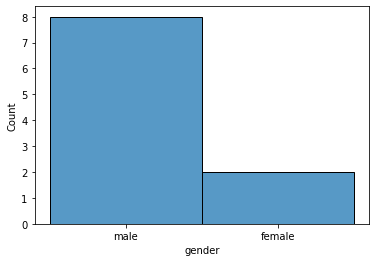

In [56]:
sns.histplot(speakers_10.gender)

([<matplotlib.patches.Wedge at 0x7f2716d929a0>,
 [Text(-0.8899187180267095, 0.6465637441936395, 'men'),
  Text(0.8899187482945414, -0.6465637025335375, 'women')])

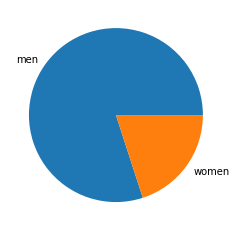

In [57]:
nb_men = speakers_10[speakers_10.gender == 'male'].speaker.count()
nb_women = 10 - nb_men

plt.pie([nb_men, nb_women], labels=['men', 'women'])